In [61]:
import csv
import numpy as np

In [62]:
data = []
with open('/content/data_ml1_v1-06.csv') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader: # each row is a list
        data.append(row)
data = np.array(data)

In [63]:
data.shape

(501, 3)

In [64]:
data

array([[2.099  , 1.1855 , 1.     ],
       [4.0897 , 2.3448 , 1.     ],
       [2.2987 , 1.5344 , 1.     ],
       ...,
       [1.2837 , 2.6584 , 4.     ],
       [0.79144, 4.1958 , 4.     ],
       [0.79144, 4.1958 , 4.     ]])

## Кросс-валидация: Holdout (70/30)

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
train_data, test_data = train_test_split(data, train_size=0.7, random_state=31)

In [67]:
for data_arr in [data, train_data, test_data]:
  data_arr[2] = data_arr[2].astype(int)

## Кодирование

In [68]:
def sort_data(data):
  sorted_data = [[],[],[],[]]
  for el in data:
    sorted_data[int(el[-1])-1].append(el[:-1])
  return sorted_data

In [69]:
def data_for_base_estimator(coding, sorted_data):
  pos_class = []
  neg_class = []
  for i in range(len(coding)):
    if coding[i] == -1:
      neg_elems = sorted_data[i]
      for el in neg_elems:
        neg_class.append(el)
    elif coding[i] == 1:
      pos_elems = sorted_data[i]
      for el in pos_elems:
        pos_class.append(el)
  X = np.append(neg_class, pos_class, axis=0)
  y = np.append(np.repeat(-1, len(neg_class)), np.repeat(1, len(pos_class)))
  return X,y

In [70]:
import pickle

In [71]:
def base_estimators(data, estimator, matr):
  sorted_data = sort_data(data)
  fitted_estimators = []
  matr_ = np.array(matr)

  for i, coding in enumerate(matr_):
    X,y = data_for_base_estimator(coding, sorted_data)
    estimator.fit(X,y)
    fitted_estimators.append(pickle.dumps(estimator))

  return fitted_estimators

In [72]:
ova_matr = [[1,-1,-1,-1],
            [-1,1,-1,-1],
            [-1,-1,1,-1],
            [-1,-1,-1,1]]
ovo_matr = [[1,-1,0,0],
            [1,0,-1,0],
            [1,0,0,-1],
            [0,1,-1,0],
            [0,1,0,-1],
            [0,0,1,-1]]

In [73]:
binary_matr = [[-1,-1,-1,1],
               [-1,-1,1,-1],
               [-1,-1,1,1],
               [-1,1,-1,-1],
               [-1,1,-1,1],
               [-1,1,1,-1],
               [-1,1,1,1]]
ternary_matr = np.append(binary_matr, 
                         [[0,-1,-1,1],
                          [-1,0,-1,1],
                          [-1,-1,0,1],
                          [0,0,-1,1],
                          [-1,0,0,1],
                          [0,-1,0,1],
                          
                          [0,-1,1,-1],
                          [-1,0,1,-1],
                          [-1,-1,1,0],
                          [-1,0,1,0],
                          [0,-1,1,0],
                          
                          [0,-1,1,1],
                          [-1,0,1,1],

                          [0,1,-1,-1],
                          [-1,1,0,-1],
                          [-1,1,-1,0],
                          [-1,1,0,0],
                          
                          [-1,1,1,0]],
                         axis=0)
ternary_matr.shape

(25, 4)

## Декодирование

In [74]:
#X = data[:, :-1]
def score_based_decoding(data, estimators, matr):
  X=data
  # y = data[:,-1].astype(int)
  posterior = []
  for estimator in estimators:
    posterior.append(pickle.loads(estimator).predict_proba(X)[:,1])

  s = []
  for i in range(len(X)):
    s_i = []
    for k in range(len(matr[0])):
      s_k = 0
      for l in range(len(estimators)): 
        s_k += matr[l][k] * (2*posterior[l][i]-1)
      s_i.append(s_k)
    s.append(s_i)
  return s

In [75]:
#X = data[:, :-1]
def score_weighted_decoding(data, estimators, matr):
  X = data
  posterior = []
  for estimator in estimators:
    posterior.append(pickle.loads(estimator).predict_proba(X)[:,1])

  s = []
  for i in range(len(X)):
    s_i = []
    for k in range(len(matr[0])):
      s_k = 0
      norm = 0
      for l in range(len(estimators)): 
        s_k += matr[l][k] * (2*posterior[l][i]-1)
        norm += abs(matr[l][k])
      s_i.append(s_k/norm)
    s.append(s_i)
  return s

## Исследование

In [76]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [77]:
ova_estimators = base_estimators(train_data, QDA(priors=[0.5,0.5], store_covariance=True), ova_matr)
ovo_estimators = base_estimators(train_data, QDA(priors=[0.5,0.5], store_covariance=True), ovo_matr)
binary_estimators = base_estimators(train_data, QDA(priors=[0.5,0.5], store_covariance=True), binary_matr)
ternary_estimators = base_estimators(train_data, QDA(priors=[0.5,0.5], store_covariance=True), ternary_matr)

In [78]:
def multiclass_predict(X, estimators, matr, scoring):
  scores = scoring(X, estimators, matr)
  predictions = [scores[i].index(max(cl_scores)) for i, cl_scores in enumerate(scores)]
  return predictions

In [79]:
ova_unw_predict_train = multiclass_predict(train_data[:, :-1], ova_estimators, ova_matr, score_based_decoding)

In [80]:
ova_unw_predict = multiclass_predict(data[:, :-1], ova_estimators, ova_matr, score_based_decoding)
ovo_unw_predict = multiclass_predict(data[:, :-1], ovo_estimators, ovo_matr, score_based_decoding)
binary_unw_predict = multiclass_predict(data[:, :-1], binary_estimators, binary_matr, score_based_decoding)
ternary_unw_predict = multiclass_predict(data[:, :-1], ternary_estimators, ternary_matr, score_based_decoding)


ova_w_predict = multiclass_predict(data[:, :-1], ova_estimators, ova_matr, score_weighted_decoding)
ovo_w_predict = multiclass_predict(data[:, :-1], ovo_estimators, ovo_matr, score_weighted_decoding)
binary_w_predict = multiclass_predict(data[:, :-1], binary_estimators, binary_matr, score_weighted_decoding)
ternary_w_predict = multiclass_predict(data[:, :-1], ternary_estimators, ternary_matr, score_weighted_decoding)

In [81]:
from matplotlib import pyplot as plt

In [82]:
data_class_ova_unw_predict = sort_data(np.append(data[:,:-1],np.array(ova_unw_predict).reshape(501,1), axis=1))
data_class_ovo_unw_predict = sort_data(np.append(data[:,:-1],np.array(ovo_unw_predict).reshape(501,1), axis=1))
data_class_binary_unw_predict = sort_data(np.append(data[:,:-1],np.array(binary_unw_predict).reshape(501,1), axis=1))
data_class_ternary_unw_predict = sort_data(np.append(data[:,:-1],np.array(ternary_unw_predict).reshape(501,1), axis=1))

data_class_ova_w_predict = sort_data(np.append(data[:,:-1],np.array(ova_unw_predict).reshape(501,1), axis=1))
data_class_ovo_w_predict = sort_data(np.append(data[:,:-1],np.array(ovo_unw_predict).reshape(501,1), axis=1))
data_class_binary_w_predict = sort_data(np.append(data[:,:-1],np.array(binary_unw_predict).reshape(501,1), axis=1))
data_class_ternary_w_predict = sort_data(np.append(data[:,:-1],np.array(ternary_unw_predict).reshape(501,1), axis=1))

### Границы классов

In [83]:
def divide_on_TF(X, y, y_predict):
  t = []
  f = []
  for i in range(len(y)):
    if int(y[i]-1) == int(y_predict[i]):
      t.append(np.append(X[i],y_predict[i]))
    else:
      # print(y[i], y_predict[i])
      f.append(np.append(X[i],y_predict[i]))
  return np.array(t), np.array(f)

In [84]:
#######################
# Unweighted decoding #
#######################
t,f = divide_on_TF(data[:,:-1], data[:,-1],ova_unw_predict)
data_class_ova_unw_predict_true = sort_data(np.array(t))
data_class_ova_unw_predict_false = sort_data(f)

t,f = divide_on_TF(data[:,:-1], data[:,-1],ovo_unw_predict)
data_class_ovo_unw_predict_true = sort_data(np.array(t))
data_class_ovo_unw_predict_false = sort_data(f)

t,f = divide_on_TF(data[:,:-1], data[:,-1],binary_unw_predict)
data_class_binary_unw_predict_true = sort_data(np.array(t))
data_class_binary_unw_predict_false = sort_data(f)

t,f = divide_on_TF(data[:,:-1], data[:,-1],ternary_unw_predict)
data_class_ternary_unw_predict_true = sort_data(np.array(t))
data_class_ternary_unw_predict_false = sort_data(f)

#######################
#  Weighted decoding  #
#######################
t,f = divide_on_TF(data[:,:-1], data[:,-1],ova_w_predict)
data_class_ova_w_predict_true = sort_data(np.array(t))
data_class_ova_w_predict_false = sort_data(f)

t,f = divide_on_TF(data[:,:-1], data[:,-1],ovo_w_predict)
data_class_ovo_w_predict_true = sort_data(np.array(t))
data_class_ovo_w_predict_false = sort_data(f)

t,f = divide_on_TF(data[:,:-1], data[:,-1],binary_w_predict)
data_class_binary_w_predict_true = sort_data(np.array(t))
data_class_binary_w_predict_false = sort_data(f)

t,f = divide_on_TF(data[:,:-1], data[:,-1],ternary_w_predict)
data_class_ternary_w_predict_true = sort_data(np.array(t))
data_class_ternary_w_predict_false = sort_data(f)

In [85]:
from matplotlib import colors
from matplotlib import cm

In [86]:
plt.rc('font', size=20)

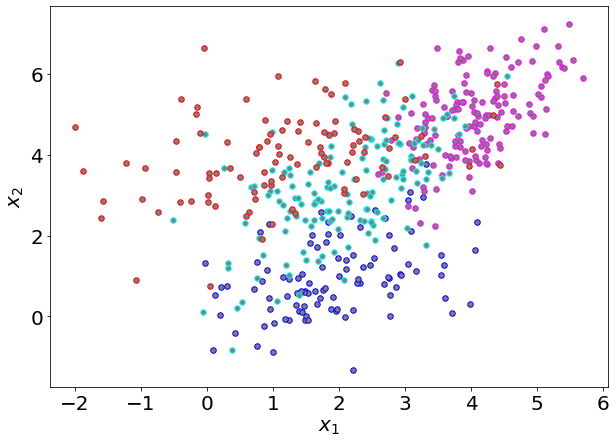

In [87]:
colors_ = [(1, 0, 0, 0.07), (0, 0, 1, 0.07), (1, 0, 1, 0.07), (0, 1, 1, 0.02)]
colors_l_ = ['blue', 'magenta', 'cyan', 'red']
plt.figure(figsize=(10,7))
sorted_data = sort_data(data)
for i in range(len(sorted_data)):
  if len(np.array(sorted_data[i]).shape) != 2:
    continue
  plt.scatter(np.array(sorted_data[i])[:,0], np.array(sorted_data[i])[:,1], s=120, marker=".",edgecolors=colors_l_[i], color='grey')
  plt.xlabel(r'$x_1$')
  plt.ylabel(r'$x_2$')

In [88]:
def draw_classified(data_class_predict_false, data_class_predict_true, estimators, matr, decoding):
  colors_ = [(1, 0, 0, 0.07), (0, 0, 1, 0.07), (1, 0, 1, 0.07), (0, 1, 1, 0.02)]
  colors_l_ = ['blue', 'magenta', 'cyan', 'red']
  plt.figure(figsize=(10,7))

  for i in range(len(data_class_predict_false)):
    if len(np.array(data_class_predict_false[i]).shape) != 2:
      continue
    if i == 0:
      plt.scatter(np.array(data_class_predict_false[i])[:,0], np.array(data_class_predict_false[i])[:,1], s=70, marker="x", color=colors_l_[i], label='incorrect classification')
      continue  
    plt.scatter(np.array(data_class_predict_false[i])[:,0], np.array(data_class_predict_false[i])[:,1], s=70, marker="x", color=colors_l_[i])

  for i in range(len(data_class_predict_true)):
    if len(np.array(data_class_predict_true[i]).shape) != 2:
      continue
    if i == 0:
      plt.scatter(np.array(data_class_predict_true[i])[:,0], np.array(data_class_predict_true[i])[:,1], s=120, marker=".",edgecolors=colors_l_[i], color='grey', label='correct classification')
      continue
    plt.scatter(np.array(data_class_predict_true[i])[:,0], np.array(data_class_predict_true[i])[:,1], s=120, marker=".",edgecolors=colors_l_[i], color='grey')
  plt.xlabel(r'$x_1$')
  plt.ylabel(r'$x_2$')

  nx, ny = 1000, 1000
  x_min, x_max = plt.xlim()
  y_min, y_max = plt.ylim()
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
  Z = multiclass_predict(np.c_[xx.ravel(), yy.ravel()], estimators, matr, decoding)
  Z = np.array(Z).reshape(xx.shape)
  cmap_ = colors.LinearSegmentedColormap.from_list('cmap_', colors_, N=500)
  plt.pcolormesh(
      xx, yy, Z, zorder=0, cmap=cmap_#, norm=colors.Normalize(0.0, 1.0)#, cmap="red_blue_classes"
  )
  plt.contour(xx, yy, Z, [0.5, 1.5, 2.5], linewidths=1.1, colors="black")
  plt.legend(loc='lower right', fontsize=12)
  return (xx, yy, Z)

In [89]:
#ova_unw_contour = draw_classified(data_class_ova_unw_predict_false, data_class_ova_unw_predict_true, ova_estimators, ova_matr, score_based_decoding)

In [90]:
#ova_w_contour = draw_classified(data_class_ova_w_predict_false, data_class_ova_w_predict_true, ova_estimators, ova_matr, score_weighted_decoding)

In [91]:
#ovo_unw_contour = draw_classified(data_class_ovo_unw_predict_false, data_class_ovo_unw_predict_true, ovo_estimators, ovo_matr, score_based_decoding)

In [92]:
#ovo_w_contour = draw_classified(data_class_ovo_w_predict_false, data_class_ovo_w_predict_true, ovo_estimators, ovo_matr, score_weighted_decoding)

In [93]:
#binary_unw_contour = draw_classified(data_class_binary_unw_predict_false, data_class_binary_unw_predict_true, binary_estimators, binary_matr, score_based_decoding)

In [94]:
#binary_w_contour = draw_classified(data_class_binary_w_predict_false, data_class_binary_w_predict_true, binary_estimators, binary_matr, score_weighted_decoding)

In [95]:
#ternary_unw_contour = draw_classified(data_class_ternary_unw_predict_false, data_class_ternary_unw_predict_true, ternary_estimators, ternary_matr, score_based_decoding)

In [96]:
#ternary_w_contour = draw_classified(data_class_ternary_w_predict_false, data_class_ternary_w_predict_true, ternary_estimators, ternary_matr, score_weighted_decoding)

In [97]:
# plt.figure(figsize=(15,9))
# c_ova_unw = plt.contour(ova_unw_contour[0], ova_unw_contour[1], ova_unw_contour[2], [0.5, 1.5, 2.5], linewidths=2, colors="black")
# c_ovo_unw = plt.contour(ovo_unw_contour[0], ovo_unw_contour[1], ovo_unw_contour[2], [0.5, 1.5, 2.5], linewidths=2, colors="green")
# c_binary_unw = plt.contour(binary_unw_contour[0], binary_unw_contour[1], binary_unw_contour[2], [0.5, 1.5, 2.5], linewidths=2, colors="orange")
# c_ternary_unw = plt.contour(ternary_unw_contour[0], ternary_unw_contour[1], ternary_unw_contour[2], [0.5, 1.5, 2.5], linewidths=2,colors="grey")

# c_ova_w = plt.contour(ova_w_contour[0], ova_w_contour[1], ova_w_contour[2], [0.5, 1.5, 2.5], linewidths=2, linestyles='dashed', colors="black")
# c_ovo_w = plt.contour(ovo_w_contour[0], ovo_w_contour[1], ovo_w_contour[2], [0.5, 1.5, 2.5], linewidths=2, linestyles='dashed', colors="green")
# c_binary_w = plt.contour(binary_w_contour[0], binary_w_contour[1], binary_w_contour[2], [0.5, 1.5, 2.5], linewidths=2, linestyles='dashed', colors="orange")
# c_ternary_w = plt.contour(ternary_w_contour[0], ternary_w_contour[1], ternary_w_contour[2], [0.5, 1.5, 2.5], linewidths=2, linestyles='dashed', colors="grey")


# labels = ['OVA - unweighted', 'OVO - unweighted','Binary -  unweighted','Ternary -  unweighted',
#           'OVA - weighted', 'OVO - weighted','Binary -  weighted','Ternary -  weighted']
# for i, cs in enumerate([c_ova_unw, c_ovo_unw, c_binary_unw, c_ternary_unw, c_ova_w, c_ovo_w, c_binary_w, c_ternary_w]):
#     cs.collections[0].set_label(labels[i])

# colors_l_ = ['blue', 'magenta', 'cyan', 'red']
# sorted_train_data = sort_data(train_data)
# sorted_test_data = sort_data(test_data)
# for i in range(len(sorted_data)):
#   if len(np.array(sorted_train_data[i]).shape) == 2:
#     plt.scatter(np.array(sorted_train_data[i])[:,0], np.array(sorted_train_data[i])[:,1], s=120, marker=".", color=colors_l_[i], label = 'train data, class {}'.format(i+1))
#   if len(np.array(sorted_test_data[i]).shape) == 2:
#     plt.scatter(np.array(sorted_test_data[i])[:,0], np.array(sorted_test_data[i])[:,1], s=120, marker="*", color=colors_l_[i], label = 'test data, class {}'.format(i+1))

# plt.xlabel(r'$x_1$')
# plt.ylabel(r'$x_2$')
# plt.legend(ncol=2, fontsize=12, loc='lower right')


### Метрики

In [98]:
K = 4

In [99]:
def conf_matr(data, estimators, matr, decoding):
  matrs = []
  c_matr = {'tp':0, 'tn':0, 'fp':0, 'fn': 0}
  for i in range(K):
    matrs.append(c_matr)
  y_predict = multiclass_predict(data[:, :-1], estimators, matr, decoding)
  for i in range(len(y_predict)):
    if y_predict[i] == int(data[i,-1]-1):
      for j in range(K):
        if int(data[i,-1]-1) == j:
          matrs[j]['tp'] += 1
        else:
          matrs[j]['tn'] += 1
    else:
      for j in range(K):
        if int(y_predict[i]) == j:
          matrs[j]['fp'] += 1
        else:
          matrs[j]['fn'] += 1
  return matrs

In [100]:
train_weigthed_cm = {}
test_weigthed_cm = {}
train_unweigthed_cm = {}
test_unweigthed_cm = {}
# weighted
train_weigthed_cm['ova'] = conf_matr(train_data, ova_estimators, ova_matr, score_weighted_decoding)
test_weigthed_cm['ova'] = conf_matr(test_data, ova_estimators, ova_matr, score_weighted_decoding)

train_weigthed_cm['ovo'] = conf_matr(train_data, ovo_estimators, ovo_matr, score_weighted_decoding)
test_weigthed_cm['ovo'] = conf_matr(test_data, ovo_estimators, ovo_matr, score_weighted_decoding)

train_weigthed_cm['binary'] = conf_matr(train_data, binary_estimators, binary_matr, score_weighted_decoding)
test_weigthed_cm['binary'] = conf_matr(test_data, binary_estimators, binary_matr, score_weighted_decoding)

train_weigthed_cm['ternary'] = conf_matr(train_data, ternary_estimators, ternary_matr, score_weighted_decoding)
test_weigthed_cm['ternary'] = conf_matr(test_data, ternary_estimators, ternary_matr, score_weighted_decoding)

# unweighted
train_unweigthed_cm['ova'] = conf_matr(train_data, ova_estimators, ova_matr, score_based_decoding)
test_unweigthed_cm['ova'] = conf_matr(test_data, ova_estimators, ova_matr, score_based_decoding)

train_unweigthed_cm['ovo'] = conf_matr(train_data, ovo_estimators, ovo_matr, score_based_decoding)
test_unweigthed_cm['ovo'] = conf_matr(test_data, ovo_estimators, ovo_matr, score_based_decoding)

train_unweigthed_cm['binary'] = conf_matr(train_data, binary_estimators, binary_matr, score_based_decoding)
test_unweigthed_cm['binary'] = conf_matr(test_data, binary_estimators, binary_matr, score_based_decoding)

train_unweigthed_cm['ternary'] = conf_matr(train_data, ternary_estimators, ternary_matr, score_based_decoding)
test_unweigthed_cm['ternary'] = conf_matr(test_data, ternary_estimators, ternary_matr, score_based_decoding)

In [101]:
(test_unweigthed_cm['binary'][0]['tp']+test_unweigthed_cm['binary'][0]['tn']+test_unweigthed_cm['binary'][0]['fp']+test_unweigthed_cm['binary'][0]['fn']) == (test_unweigthed_cm['binary'][1]['tp']+test_unweigthed_cm['binary'][1]['tn']+test_unweigthed_cm['binary'][1]['fp']+test_unweigthed_cm['binary'][1]['fn'])

True

### Точность

In [102]:
def acc(cms): #confusion_matrixes
  num = 0
  for i in range(K):
    num += cms[i]['tp']+cms[i]['tn']
  den = K*(cms[i]['tp']+cms[i]['tn']+cms[i]['fp']+cms[i]['fn'])
  return num/den

In [103]:
accuracy_train_weighted = {}
accuracy_test_weighted = {}
accuracy_train_unweighted = {}
accuracy_test_unweighted = {}
# train
for key, cms in train_weigthed_cm.items():
  accuracy_train_weighted[key] = acc(cms)
for key, cms in train_unweigthed_cm.items():
  accuracy_train_unweighted[key] = acc(cms)
# test
for key, cms in test_weigthed_cm.items():
  accuracy_test_weighted[key] = acc(cms)
for key, cms in test_unweigthed_cm.items():
  accuracy_test_unweighted[key] = acc(cms)

In [104]:
accuracy_train_weighted

{'binary': 0.7457142857142857,
 'ova': 0.7514285714285714,
 'ovo': 0.7571428571428571,
 'ternary': 0.7457142857142857}

на обучающей выборке

In [105]:
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.16       # the width of the bars

plt.figure(figsize=(15,8))
ova = plt.bar(ind, height=[accuracy_train_weighted['ova'],accuracy_train_unweighted['ova']], width=width, color='r', alpha=0.5)
ovo = plt.bar(ind+width, height=[accuracy_train_weighted['ovo'],accuracy_train_unweighted['ovo']], width=width, color='g', alpha=0.5)
bin = plt.bar(ind+width*2, height=[accuracy_train_weighted['binary'],accuracy_train_unweighted['binary']], width=width, color='b', alpha=0.5)
tern = plt.bar(ind+width*3, height=[accuracy_train_weighted['ternary'],accuracy_train_unweighted['ternary']], width=width, color='grey', alpha=0.7)

plt.xticks([r + width*1.5 for r in range(len(['weighted', 'unweighted']))], ['score-weighted decoding', 'score-based decoding'] )
plt.ylabel('accuracy')
plt.legend( (ova[0], ovo[0], bin[0], tern[0]),  accuracy_train_weighted.keys(), fontsize=15)

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2., 1.001*h, '{:5.4f}'.format(h),
                ha='center', va='bottom', fontsize=15)

autolabel(ova)
autolabel(ovo)
autolabel(tern)
autolabel(bin)

на тестовой выборке

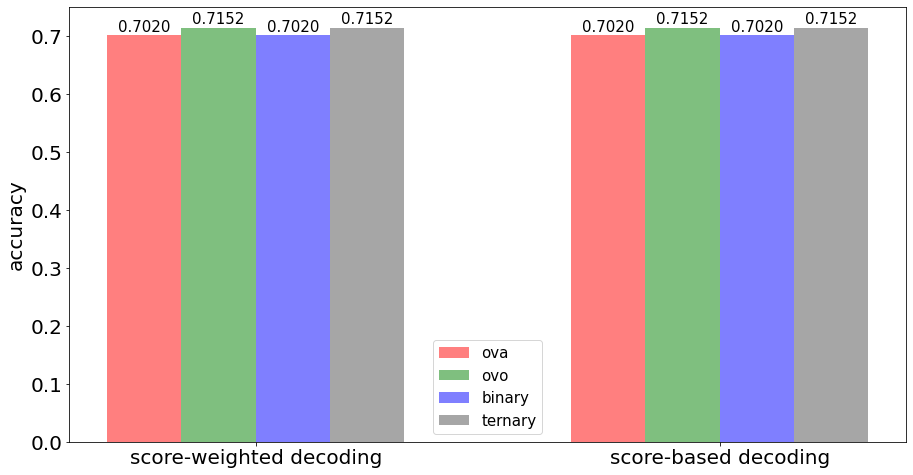

In [106]:
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.16       # the width of the bars

plt.figure(figsize=(15,8))
ova = plt.bar(ind, height=[accuracy_test_weighted['ova'],accuracy_test_unweighted['ova']], width=width, color='r', alpha=0.5)
ovo = plt.bar(ind+width, height=[accuracy_test_weighted['ovo'],accuracy_test_unweighted['ovo']], width=width, color='g', alpha=0.5)
bin = plt.bar(ind+width*2, height=[accuracy_test_weighted['binary'],accuracy_test_unweighted['binary']], width=width, color='b', alpha=0.5)
tern = plt.bar(ind+width*3, height=[accuracy_test_weighted['ternary'],accuracy_test_unweighted['ternary']], width=width, color='grey', alpha=0.7)

plt.xticks([r + width*1.5 for r in range(len(['weighted', 'unweighted']))], ['score-weighted decoding', 'score-based decoding'] )
plt.ylabel('accuracy')
plt.legend( (ova[0], ovo[0], bin[0], tern[0]),  accuracy_test_weighted.keys(), fontsize=15)

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2., 1.001*h, '{:5.4f}'.format(h),
                ha='center', va='bottom', fontsize=15)

autolabel(ova)
autolabel(ovo)
autolabel(tern)
autolabel(bin)

### ROC

In [126]:
def macro_cm(data, score_decoding, estimators, matr):
  X = data[:,:-1]
  scores = score_decoding(X, estimators, matr)
  cms = []
  thresholds = []
  for i in range(K):
    cms_i = []
    # sort data by score for i-th class
    data_to_sort = [(x,scores[j][i]) for j,x in enumerate(data)]
    sorted_data = sorted(data_to_sort, key = lambda data_to_sort: data_to_sort[1])
    # create thresholds
    scores_i = [x[1] for x in sorted_data]
    thresholds_i = [(x+scores_i[j+1])/2 for j,x in enumerate(scores_i[:-1])]
    thresholds_i.insert(0, scores_i[0]-0.1)
    thresholds_i.append(scores_i[-1]+0.1)
    thresholds.append(thresholds_i)
    #     
    for j in range(len(thresholds_i)):
      if j == 0:
        cms_ij = {'tp':0, 'tn':0, 'fp':0, 'fn':0}
        # # the only one is predicted as negative
        # if sorted_data[0][0][2] != i:
        #   cms_ij['tn'] +=1
        # else:
        #   cms_ij['fn'] +=1
        # others are predicted as positive
        for l in range(0, len(sorted_data)):
          if sorted_data[l][0][2]-1 == i:
            cms_ij['tp'] +=1
          else:
            cms_ij['fp'] +=1
      else: # take previous conf matr and change one element
        cms_ij = cms_i[-1].copy()
        if sorted_data[j-1][0][2]-1 != i:
          cms_ij['fp'] -=1
          cms_ij['tn'] +=1
        else:
          cms_ij['tp'] -=1
          cms_ij['fn'] +=1

      cms_i.append(cms_ij)
      # if i ==0 and j < 10:
        # print(j, cms_i)
    cms.append(cms_i)
  return cms, thresholds

In [127]:
def micro_cm(cms, thrs):
  if len(cms) != len(thrs):
    print('different number of classes in cms and thrs lists')
    return
  for i in range(len(thrs)):
    if len(cms[i]) != len(thrs[i]):
      print('different number of elements in {0} class in cms and thrs lists'.format(i))
      return

  m_cms = []
  m_thrs = []
  indx = [0,0,0,0]

  while True:
    curr_cms_i = {'tp':0, 'tn':0, 'fp':0, 'fn':0}
    for key in curr_cms_i.keys():
      for i in range(K):
        curr_cms_i[key] += cms[i][indx[0]][key]
    m_cms.append(curr_cms_i)
    future_thrs = [thrs[0][indx[0]+1], thrs[1][indx[1]+1], thrs[2][indx[2]+1], thrs[3][indx[3]+1]]
    sorted_future_thrs = sorted(enumerate(future_thrs), key = lambda t: t[1])
    i = 0
    min = sorted_future_thrs[i]
    flag = False
    while indx[min[0]] >= (len(thrs[0])-2):
      i += 1
      if i > 3:
        flag = True
        break
      else:
        min = sorted_future_thrs[i]

    if flag == True:
      break
    # END while indx[min[0]] >= (len(thrs[0])-2)
    
    # shift a threshold
    m_thrs.append(min[1])
    indx[min[0]] +=1
  # END while True
  
  # add first and last thresholds
  m_thrs.insert(0, m_thrs[0]-0.1)
  m_thrs.append(m_thrs[-1]+0.1)
  # add last cm
  curr_cms_i = {'tp':0, 'tn':0, 'fp':0, 'fn':0}
  for key in curr_cms_i.keys():
      for i in range(K):
        curr_cms_i[key] += cms[i][-1][key]  
  m_cms.append(curr_cms_i)

  return m_cms,m_thrs

In [121]:
def binary_sens(cm):
  return cm['tp']/(cm['tp']+cm['fn']) if (cm['tp']+cm['fn']) !=0 else 0

def binary_spec(cm):
  return cm['tn']/(cm['tn']+cm['fp'])

def binary_prec(cm):
  return cm['tp']/(cm['tp']+cm['fp'])

In [122]:
#score_based_decoding
#train
macro_cms_train, macro_thrs_train = macro_cm(train_data, score_based_decoding)
micro_cms_train, micro_thrs_train = micro_cm(macro_cms_train, macro_thrs_train)
#test
macro_cms_test, macro_thrs_test = macro_cm(test_data, score_based_decoding)
micro_cms_test, micro_thrs_test = micro_cm(macro_cms_test, macro_thrs_test)

# score_weighted_decoding
#train
macro_cms_train_w, macro_thrs_train = macro_cm(train_data, score_weighted_decoding)
micro_cms_train_w, micro_thrs_train = micro_cm(macro_cms_train, macro_thrs_train)
#test
macro_cms_test_w, macro_thrs_test = macro_cm(test_data, score_weighted_decoding)
micro_cms_test_w, micro_thrs_test = micro_cm(macro_cms_test, macro_thrs_test)

In [123]:
#score_based_decoding
#macro
#train
macro_m_sens_train = [[1-binary_sens(cm) for cm in k_cms] for k_cms in macro_cms_train]
macro_avg_m_sens_train = [np.sum(x)/K for x in np.array(macro_m_sens_train).T] 
macro_spec_train = [[binary_spec(cm) for cm in k_cms] for k_cms in macro_cms_train] 
macro_avg_spec_train = [np.sum(x)/K for x in np.array(macro_spec_train).T]
#test
macro_m_sens_test = [[1-binary_sens(cm) for cm in k_cms] for k_cms in macro_cms_test] 
macro_avg_m_sens_test = [np.sum(x)/K for x in np.array(macro_m_sens_test).T] 
macro_spec_test = [[binary_spec(cm) for cm in k_cms] for k_cms in macro_cms_test] 
macro_avg_spec_test = [np.sum(x)/K for x in np.array(macro_spec_test).T]
#micro
#train
micro_m_sens_train = [1-binary_sens(cm) for cm in micro_cms_train]
micro_spec_train = [binary_spec(cm) for cm in micro_cms_train]
#test
micro_m_sens_test = [1-binary_sens(cm) for cm in micro_cms_test]
micro_spec_test = [binary_spec(cm) for cm in micro_cms_test]

# score_weighted_decoding
#macro
#train
macro_m_sens_train_w = [[1-binary_sens(cm) for cm in k_cms] for k_cms in macro_cms_train_w] 
macro_avg_m_sens_train_w = [1-np.sum(x)/K for x in 1-np.array(macro_m_sens_train_w).T] 
macro_spec_train_w = [[binary_spec(cm) for cm in k_cms] for k_cms in macro_cms_train_w] 
macro_avg_spec_train_w = [1-np.sum(x)/K for x in 1-np.array(macro_spec_train_w).T]
#test
macro_m_sens_test_w = [[1-binary_sens(cm) for cm in k_cms] for k_cms in macro_cms_test_w] 
macro_avg_m_sens_test_w = [1-np.sum(x)/K for x in 1-np.array(macro_m_sens_test_w).T] 
macro_spec_test_w = [[binary_spec(cm) for cm in k_cms] for k_cms in macro_cms_test_w] 
macro_avg_spec_test_w = [1-np.sum(x)/K for x in 1-np.array(macro_spec_test_w).T]
#micro
#train
micro_m_sens_train_w = [1-binary_sens(cm) for cm in micro_cms_train_w]
micro_spec_train_w = [binary_spec(cm) for cm in micro_cms_train_w]
#test
micro_m_sens_test_w = [1-binary_sens(cm) for cm in micro_cms_test_w]
micro_spec_test_w = [binary_spec(cm) for cm in micro_cms_test_w]

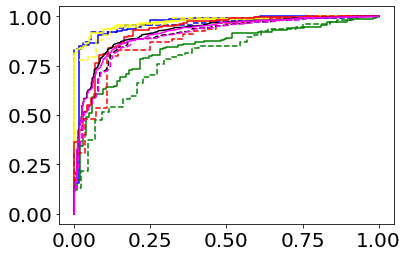

In [124]:
ccolors = ['blue', 'yellow', 'green', 'red']
for i in range(K):
  plt.plot(macro_m_sens_train[i],macro_spec_train[i], label='[train] {0} class'.format(i), color=ccolors[i])
  plt.plot(macro_m_sens_test[i],macro_spec_test[i], label='[test] {0} class'.format(i), color=ccolors[i], linestyle='--')
plt.plot(macro_avg_m_sens_train,macro_avg_spec_train, label='[train] avg', color='black')
plt.plot(macro_avg_m_sens_test,macro_avg_spec_test, label='[test] avg', color='black', linestyle='--')
# plt.legend(title='macro averaged')
plt.plot(micro_m_sens_train,micro_spec_train, label='[train] micro avg', color='magenta')
plt.plot(micro_m_sens_test,micro_spec_test, label='[test] micro avg', color='magenta', linestyle='--')


In [125]:
np.trapz(y=micro_spec_train,x=micro_m_sens_train)

0.9160761904761904

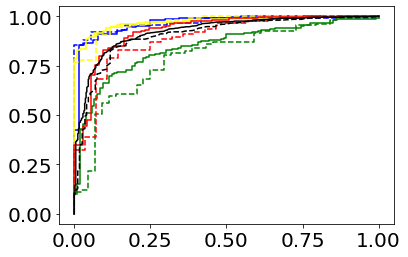

In [118]:
ccolors = ['blue', 'yellow', 'green', 'red']
for i in range(K):
  plt.plot(macro_m_sens_train_w[i],macro_spec_train_w[i], label='[train] {0} class'.format(i), color=ccolors[i])
  plt.plot(macro_m_sens_test_w[i],macro_spec_test_w[i], label='[test] {0} class'.format(i), color=ccolors[i], linestyle='--')
plt.plot(macro_avg_m_sens_train_w,macro_avg_spec_train_w, label='[train] avg', color='black')
plt.plot(macro_avg_m_sens_test_w,macro_avg_spec_test_w, label='[test] avg', color='black', linestyle='--')
# plt.legend(title='macro averaged')